# Using a Convolutional-Recurrent Neural Network to Predict the Effect of SNPs, Part 2

Okay. Learning from the previous failures, we can come up with some new techniques for making the network better.

1. Train using both 5' and 3' data (because we want to learn a model for skipped exons)
2. Use a deeper model? More layers?

Honestly this notebook is a mess. I tried training and re-training the models over and over, and sometimes testing results in incongrouous places.

In [1]:
%matplotlib inline
from keras.models import Sequential, model_from_json
from keras.layers import Convolution1D, LSTM, GRU, Dense, Activation, Dropout
from keras.objectives import binary_crossentropy, categorical_crossentropy
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.preprocessing import sequence

import sys
import os
sys.path.append(os.path.abspath('../src/'))
import nn_utils
reload(nn_utils)

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import r2_score

import tqdm

Using Theano backend.


## Loading Synthetic Data

This time we'll be loading both alt-5' and alt-3' data.

In [2]:
X_train, X_test, Y_train, Y_test = nn_utils.load_a5_data()
Y2_test = Y_test[:,44]
Y2_train = Y_train[:,44]
X1_train = X_train.map(lambda x: x[0:25])
X1_test = X_test.map(lambda x: x[0:25])
#X1_train = X1_train.map(lambda x: np.rollaxis(x, 1))
#X1_test = X1_test.map(lambda x: np.rollaxis(x, 1))
X1_train = np.dstack(X1_train)
X1_train = np.rollaxis(X1_train, 2)
X1_test = np.dstack(X1_test)
X1_test = np.rollaxis(X1_test, 2)

Y2_train = Y2_train.reshape((len(Y2_train), 1))
Y2_test = Y2_test.reshape((len(Y2_test), 1))

In [3]:
X_a3_train, X_a3_test, Y_a3_train, Y_a3_test = nn_utils.load_a3_data()
# position 235 corresponds to splice site 1?
Y2_a3_test = Y_a3_test[:,235]
Y2_a3_train = Y_a3_train[:,235]
X1_a3_train = X_a3_train.map(lambda x: x[25:])
X1_a3_test = X_a3_test.map(lambda x: x[25:])
#X1_train = X1_train.map(lambda x: np.rollaxis(x, 1))
#X1_test = X1_test.map(lambda x: np.rollaxis(x, 1))
X1_a3_train = np.dstack(X1_a3_train)
X1_a3_train = np.rollaxis(X1_a3_train, 2)
X1_a3_test = np.dstack(X1_a3_test)
X1_a3_test = np.rollaxis(X1_a3_test, 2)

Y2_a3_train = Y2_a3_train.reshape((len(Y2_a3_train), 1))
Y2_a3_test = Y2_a3_test.reshape((len(Y2_a3_test), 1))

In [54]:
X_train = np.concatenate((X1_train, X1_a3_train), axis=0)
Y_train = np.concatenate((Y2_train, Y2_a3_train), axis=0)

## Loading Biological Data

In [4]:
table1 = pd.read_table('../data/mmc2.tsv')
wt_seqs = table1.WT_SEQ
mut_seqs = table1.MUT_SEQ
wt_seqs_encoded = [nn_utils.seq_to_array(x) for x in wt_seqs]
mut_seqs_encoded = [nn_utils.seq_to_array(x) for x in mut_seqs]
wt_seqs_encoded = map(lambda x: x.reshape((1, x.shape[0], x.shape[1])), wt_seqs_encoded)
mut_seqs_encoded = map(lambda x: x.reshape((1, x.shape[0], x.shape[1])), mut_seqs_encoded)

## Training a Model

Notes on model-building: I tried a variety of parameters and models. Training w/o dropout, the best I did was with a 64-filter convnet + 64-unit lstm with the alt-5 data, which got an r2 of 0.62 on test. Adding an additional convolutional layer didn't seem to make things better in practice. Maybe I can try some deeper layering with purely recurrent layers. Or maybe a smaller architecture with just a few recurrent units, to mimic the behavior of basically just summing the convolutional unit outputs (which can be considered as being roughly equivalent to the HAL model of summing the score from each 6-mer).

In [5]:
num_filters = [128,64,64]
filter_length = [6,6]


model1 = Sequential()
model1.add(Convolution1D(num_filters[0], filter_length[0], activation='relu', input_dim=4))
model1.add(Dropout(0.25))
model1.add(Convolution1D(num_filters[1], filter_length[1], activation='relu'))
model1.add(Dropout(0.25))
model1.add(GRU(output_dim=num_filters[-1]))
model1.add(Dense(output_dim=1, activation='linear'))
model1.add(Activation('sigmoid'))

In [6]:
model1.compile(loss='binary_crossentropy',
              optimizer='adam')

In [7]:
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

model1.fit(X1_train, Y2_train,
          nb_epoch=50,
          batch_size=500,
          show_accuracy=True,
          validation_data=(X1_test, Y2_test),
          callbacks=[early_stopping])

Train on 212035 samples, validate on 53009 samples
Epoch 1/50
212035/212035 [==============================] - 2493s - loss: 0.5903 - acc: 1.0000 - val_loss: 0.5442 - val_acc: 1.0000
Epoch 2/50
212035/212035 [==============================] - 2381s - loss: 0.5439 - acc: 1.0000 - val_loss: 0.5367 - val_acc: 1.0000
Epoch 3/50
212035/212035 [==============================] - 2391s - loss: 0.5340 - acc: 1.0000 - val_loss: 0.5192 - val_acc: 1.0000
Epoch 4/50
212035/212035 [==============================] - 2388s - loss: 0.5276 - acc: 1.0000 - val_loss: 0.5166 - val_acc: 1.0000
Epoch 5/50
212035/212035 [==============================] - 2299s - loss: 0.5241 - acc: 1.0000 - val_loss: 0.5129 - val_acc: 1.0000
Epoch 6/50
212035/212035 [==============================] - 2371s - loss: 0.5223 - acc: 1.0000 - val_loss: 0.5110 - val_acc: 1.0000
Epoch 7/50
212035/212035 [==============================] - 2370s - loss: 0.5196 - acc: 1.0000 - val_loss: 0.5092 - val_acc: 1.0000
Epoch 8/50
212035/212035 

In [8]:
predictions = model1.predict(X1_test)

In [9]:
r2_score(Y2_test, predictions)

0.62318192628798719

/usr/local/lib/python2.7/dist-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


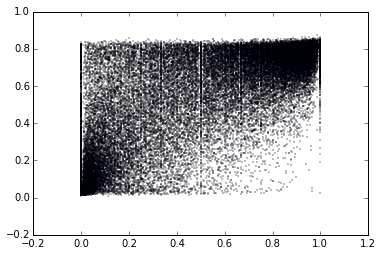

In [10]:
plt.scatter(Y2_test, predictions, s=0.1)
plt.show()

In [59]:
predictions2 = model1.predict(X1_a3_test)

In [62]:
r2_score(predictions2, Y2_a3_test)

-0.42790190487558011

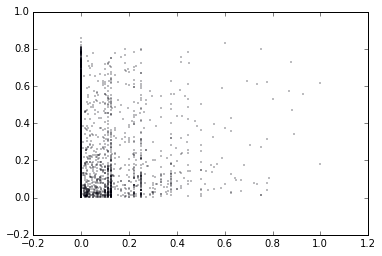

In [63]:
plt.scatter(Y2_a3_test, predictions2, s=0.1)
plt.show()

In [67]:
predictions2 = model1.predict(X1_a3_train)

In [68]:
r2_score(Y2_a3_train, predictions2)

-7.1965882945431705

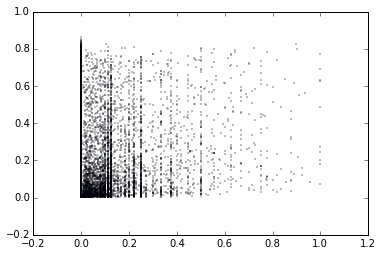

In [69]:
plt.scatter(Y2_a3_train, predictions2, s=0.1)
plt.show()

In [17]:
model1.save_weights('../data/convolutional-recurrent-5.h5')
model_json = model1.to_json()
with open('../data/convolutional-recurrent-5-model.json', 'w') as f:
    f.write(model_json)

## Loading the Model, Testing dPSI Predictions

Before we do anything else, we should probably have a way of calculating the score of a sequence using the NN model rather than just a probability, so that we can use the same dPSI calculations as for HAL.

In [5]:
model1 = model_from_json(open('../data/convolutional-recurrent-3-model.json').read())

In [6]:
model1.load_weights('../data/convolutional-recurrent-3.h5')

In [10]:
from keras import backend as K


In [11]:
model1.layers    

In [12]:
get_3rd_layer_output = K.function([model1.layers[0].input],
                                  [model1.layers[3].get_output(train=False)])

WARNING (theano.gof.compilelock): Overriding existing lock by dead process '11643' (I am process '4760')


In [18]:
def get_score(input_data):
    return get_3rd_layer_output([input_data])[0]

In [20]:
# tests
get_score(wt_seqs_encoded[0])

array([[-4.68314505]], dtype=float32)

In [21]:
get_score(mut_seqs_encoded[0])

array([[-4.39202929]], dtype=float32)

In [15]:
expit = lambda x: 1./(1.+np.exp(-x))
logit = lambda x: np.log(x)-np.log(1-x)

In [27]:
def get_delta_psi(wt_seq, mut_seq, wt_psi):
    score_wt = get_score(wt_seq)
    score_mut = get_score(mut_seq)
    mut_psi = expit(score_mut - score_wt + logit(wt_psi))
    return mut_psi - wt_psi

In [46]:
nn_delta_psi = [get_delta_psi(w, m, p) for w, m, p in tqdm.tqdm(zip(wt_seqs_encoded, mut_seqs_encoded, table1.WT_PSI))]

In [47]:
model_dpsi_pred = [x[0][0] for x in nn_delta_psi]

In [48]:
hal_pred = []
model_pred = []
for h, m in zip(table1.HOMO_DPSI_PRED, model_dpsi_pred):
    if h!=None and h>=-1 and h<=1:
        hal_pred.append(h)
        model_pred.append(m)

In [54]:
r2_score(hal_pred, model_pred)

-0.18481512793308164

/usr/local/lib/python2.7/dist-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


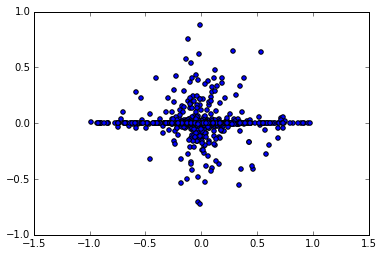

In [55]:
plt.scatter(hal_pred, model_pred)

In [59]:
score_mut = hal_pred_2 = []
model_pred_2 = []
actual = []
for h, m, a in zip(table1.HOMO_DPSI_PRED, model_dpsi_pred, table1.HOMO_DPSI):
    if h!=None and h>=-1 and h<=1 and a>=-1 and a<=1:
        hal_pred_2.append(h)
        model_pred_2.append(m)
        actual.append(a)

In [60]:
r2_score(actual, model_pred_2)

-0.2470763497629489

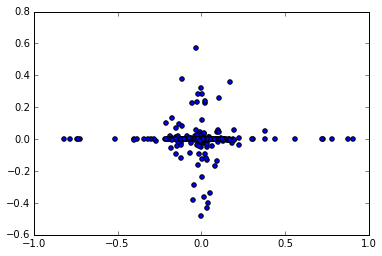

In [61]:
plt.scatter(actual, model_pred_2)

## Using an Older Model

In [62]:
model = model_from_json(open('../data/convolutional-recurrent-model.json').read())
model.load_weights('../data/convolutional-recurrent.h5')

In [66]:
get_3rd_layer_output = K.function([model.layers[0].input],
                                  [model.layers[2].get_output(train=False)])

In [64]:
model.layers

The older model doesn't work. Moving on...

## Training Solely on Alt-3' Splicing Data

In [67]:
num_filters = [64,32]
filter_length = [6,6]


model2 = Sequential()
model2.add(Convolution1D(num_filters[0], filter_length[0], activation='relu', input_dim=4))
model2.add(Convolution1D(num_filters[1], filter_length[1], activation='relu'))
model2.add(LSTM(output_dim=num_filters[-1]))
model2.add(Dense(output_dim=1, activation='linear'))
model2.add(Activation('sigmoid'))

In [68]:
model2.compile(loss='binary_crossentropy',
              optimizer='adam')

In [73]:
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

model2.fit(X1_a3_train, Y2_a3_train,
          nb_epoch=50,
          batch_size=500,
          show_accuracy=True,
          validation_data=(X1_a3_test, Y2_a3_test),
          callbacks=[early_stopping])

Train on 66240 samples, validate on 16560 samples
Epoch 1/50
66240/66240 [==============================] - 198s - loss: 0.0706 - acc: 1.0000 - val_loss: 0.0657 - val_acc: 1.0000
Epoch 2/50
66240/66240 [==============================] - 198s - loss: 0.0692 - acc: 1.0000 - val_loss: 0.0642 - val_acc: 1.0000
Epoch 3/50
66240/66240 [==============================] - 198s - loss: 0.0683 - acc: 1.0000 - val_loss: 0.0636 - val_acc: 1.0000
Epoch 4/50
66240/66240 [==============================] - 198s - loss: 0.0673 - acc: 1.0000 - val_loss: 0.0621 - val_acc: 1.0000
Epoch 5/50
66240/66240 [==============================] - 198s - loss: 0.0657 - acc: 1.0000 - val_loss: 0.0612 - val_acc: 1.0000
Epoch 6/50
66240/66240 [==============================] - 201s - loss: 0.0641 - acc: 1.0000 - val_loss: 0.0601 - val_acc: 1.0000
Epoch 7/50
66240/66240 [==============================] - 198s - loss: 0.0632 - acc: 1.0000 - val_loss: 0.0599 - val_acc: 1.0000
Epoch 8/50
66240/66240 [=======================

In [79]:
# ugh it's just going to assign everything to zero isn't it... i honestly hate this
predictions = model2.predict(X1_a3_test)

In [80]:
r2_score(Y2_a3_test, predictions)

0.083706603715762662

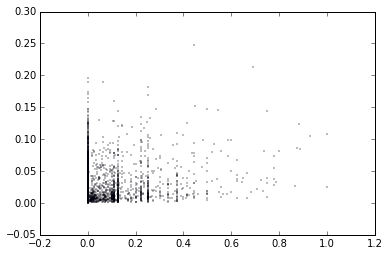

In [81]:
plt.scatter(Y2_a3_test, predictions, s=0.1)
plt.show()

In [82]:
predictions2 = model2.predict(X1_a3_train)

In [83]:
r2_score(Y2_a3_train, predictions2)

0.11644977216049768

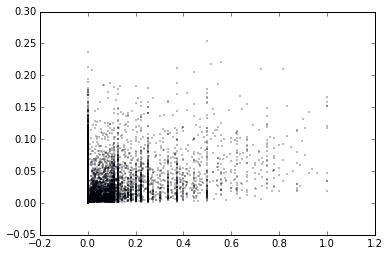

In [84]:
plt.scatter(Y2_a3_train, predictions2, s=0.1)
plt.show()

In [122]:
model2.save_weights('../data/convolutional-recurrent-a3.h5', overwrite=True)
model_json = model2.to_json()
with open('../data/convolutional-recurrent-a3-model.json', 'w') as f:
    f.write(model_json)

## Predicting Using a Combination of Both Models

In [11]:
get_3rd_layer_output_2 = K.function([model2.layers[0].input],
                                  [model2.layers[3].get_output(train=False)])
get_3rd_layer_output_1 = K.function([model1.layers[0].input],
                                  [model1.layers[3].get_output(train=False)])
def get_score(input_data):
    #return get_3rd_layer_output_1([input_data])[0]
    return (get_3rd_layer_output_2([input_data])[0] + get_3rd_layer_output_1([input_data])[0])/2

def get_delta_psi(wt_seq, mut_seq, wt_psi):
    score_wt = get_score(wt_seq)
    score_mut = get_score(mut_seq)
    mut_psi = expit(score_mut - score_wt + logit(wt_psi))
    return mut_psi - wt_psi

NameError: name 'K' is not defined

In [135]:
nn_delta_psi = [get_delta_psi(w, m, p) for w, m, p in tqdm.tqdm(zip(wt_seqs_encoded, mut_seqs_encoded, table1.WT_PSI))]

In [136]:
model_dpsi_pred = [x[0][0] for x in nn_delta_psi]
hal_pred = []
model_pred = []
for h, m in zip(table1.HOMO_DPSI_PRED, model_dpsi_pred):
    if h!=None and h>=-1 and h<=1:
        hal_pred.append(h)
        model_pred.append(m)

In [137]:
r2_score(hal_pred, model_pred)

-0.00040111979268298015

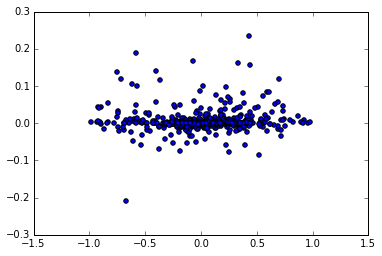

In [138]:
plt.scatter(hal_pred, model_pred)

In [27]:
score_mut = hal_pred_2 = []
model_pred_2 = []
actual = []
for h, m, a in zip(table1.HOMO_DPSI_PRED, model_dpsi_pred, table1.HOMO_DPSI):
    if h!=None and h>=-1 and h<=1 and a>=-1 and a<=1:
        hal_pred_2.append(h)
        model_pred_2.append(m)
        actual.append(a)

In [28]:
r2_score(actual, model_pred_2)

-0.022846361200620002

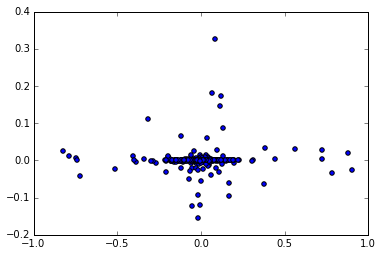

In [29]:
plt.scatter(actual, model_pred_2)

In [142]:
model1.layers

## Trying More Models for A3 Data

Here, we'll try different combinations of num_filters and numbers of layers.

Two layers - 128 convolutional units, 64 GRU units

In [32]:
num_filters = [128,64, 64]
filter_length = [6,6]

model2 = Sequential()
model2.add(Convolution1D(num_filters[0], filter_length[0], activation='relu', input_dim=4))
model2.add(Dropout(0.25))
model2.add(Convolution1D(num_filters[1], filter_length[1], activation='relu'))
model2.add(Dropout(0.25))
model2.add(GRU(output_dim=num_filters[-1]))
model2.add(Dense(output_dim=1, activation='linear'))
model2.add(Activation('sigmoid'))

In [33]:
model2.compile(loss='binary_crossentropy',
              optimizer='adam')

In [34]:
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

model2.fit(X1_a3_train, Y2_a3_train,
          nb_epoch=50,
          batch_size=500,
          show_accuracy=True,
          validation_data=(X1_a3_test, Y2_a3_test),
          callbacks=[early_stopping])

Train on 66240 samples, validate on 16560 samples
Epoch 1/50
66240/66240 [==============================] - 768s - loss: 0.1893 - acc: 1.0000 - val_loss: 0.0684 - val_acc: 1.0000
Epoch 2/50
66240/66240 [==============================] - 797s - loss: 0.0718 - acc: 1.0000 - val_loss: 0.0669 - val_acc: 1.0000
Epoch 3/50
66240/66240 [==============================] - 745s - loss: 0.0710 - acc: 1.0000 - val_loss: 0.0664 - val_acc: 1.0000
Epoch 4/50
66240/66240 [==============================] - 750s - loss: 0.0708 - acc: 1.0000 - val_loss: 0.0663 - val_acc: 1.0000
Epoch 5/50
66240/66240 [==============================] - 736s - loss: 0.0708 - acc: 1.0000 - val_loss: 0.0663 - val_acc: 1.0000
Epoch 6/50
66240/66240 [==============================] - 733s - loss: 0.0708 - acc: 1.0000 - val_loss: 0.0663 - val_acc: 1.0000
Epoch 7/50
66240/66240 [==============================] - 728s - loss: 0.0708 - acc: 1.0000 - val_loss: 0.0663 - val_acc: 1.0000
Epoch 8/50
66240/66240 [=======================

## Final Predictions

In [35]:
predictions = model2.predict(X1_a3_test)

In [36]:
r2_score(Y2_a3_test, predictions)

0.070470407307286709

In [37]:
from keras import backend as K

get_3rd_layer_output_2 = K.function([model2.layers[0].input],
                                  [model2.layers[5].get_output(train=False)])
get_3rd_layer_output_1 = K.function([model1.layers[0].input],
                                  [model1.layers[5].get_output(train=False)])
def get_score(input_data):
    #return get_3rd_layer_output_1([input_data])[0]
    return (get_3rd_layer_output_2([input_data])[0] + get_3rd_layer_output_1([input_data])[0])/2

def get_delta_psi(wt_seq, mut_seq, wt_psi):
    score_wt = get_score(wt_seq)
    score_mut = get_score(mut_seq)
    mut_psi = expit(score_mut - score_wt + logit(wt_psi))
    return mut_psi - wt_psi

In [38]:
nn_delta_psi = [get_delta_psi(w, m, p) for w, m, p in tqdm.tqdm(zip(wt_seqs_encoded, mut_seqs_encoded, table1.WT_PSI))]

In [39]:
model_dpsi_pred = [x[0][0] for x in nn_delta_psi]
hal_pred = []
model_pred = []
for h, m in zip(table1.HOMO_DPSI_PRED, model_dpsi_pred):
    if h!=None and h>=-1 and h<=1:
        hal_pred.append(h)
        model_pred.append(m)

In [40]:
r2_score(hal_pred, model_pred)

0.011079979697108833

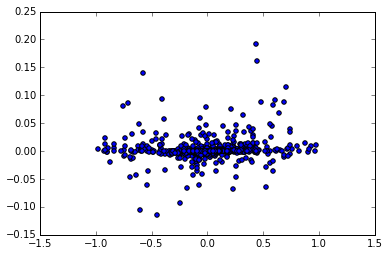

In [41]:
plt.scatter(hal_pred, model_pred)

In [21]:
model1.layers

In [42]:
model2.save_weights('../data/convolutional-recurrent-a3-2.h5')
model_json = model2.to_json()
with open('../data/convolutional-recurrent-a3-model-2.json', 'w') as f:
    f.write(model_json)